<a href="https://colab.research.google.com/github/rymuelle/10_0_X_alignment_residual_check/blob/master/simpleCFBMinimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import pandas as pd
from google.colab import files, drive
import os
import math
import matplotlib.pyplot as plt

In [0]:
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0")

Mount drive and get our game CSV:

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
game_history=pd.read_csv('/content/drive/My Drive/Colab Notebooks/CFB_pytorch_toy_minimizer/game_history.csv')
game_history_2019=game_history[game_history.season.fillna(0).astype(int)==2019]
game_history_2019.head()

,team1,team2,team1Home,score1,score2,ordinal_date,season
98528,St Mary's NS,St Fran Xavier,-1,39,7.0,737288.0,2019.0
98529,Acadia,Mt Allison,-1,13,29.0,737288.0,2019.0
98530,Manitoba,Regina,-1,12,9.0,737292.0,2019.0
98531,Coffeyville CC,Iowa Western CC,-1,14,36.0,737293.0,2019.0
98532,Hutchinson CC,Ellsworth CC,-1,41,16.0,737293.0,2019.0


(array([206., 836., 819., 796., 867., 814., 586., 134.,  27.,  20.]),
 array([737288. , 737302.9, 737317.8, 737332.7, 737347.6, 737362.5,
        737377.4, 737392.3, 737407.2, 737422.1, 737437. ]),
 <a list of 10 Patch objects>)

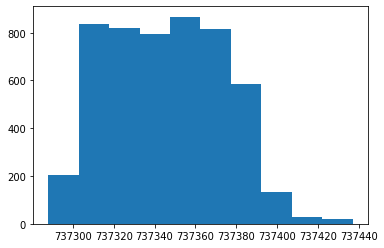

In [5]:
plt.hist(game_history_2019.ordinal_date, 10)

Now, build list and dict of teams. Dict converts between index and name, list stores team power

In [0]:
team_list=pd.concat([game_history_2019.team1,game_history_2019.team2]).unique()
team_list=np.append(team_list,'home_field')
team_dict={team:count for count,team in enumerate(team_list)}

We've added a cutoff here for some rough testing:

In [0]:
count=0
lengthX=len(team_list)
game_array=[]
spread_array=[]
game_array_test=[]
spread_array_test=[]
cutoff=1000000
for index, row in game_history_2019.iterrows():
  game=np.zeros(lengthX)
  game[team_dict[row.team1]]=1
  game[team_dict[row.team2]]=-1
  game[lengthX-1]=row.team1Home
  spread = row.score1-row.score2
  if not math.isnan(spread):
    if row.ordinal_date<cutoff: 
      game_array.append(game)
      spread_array.append(spread)
    else:
      game_array_test.append(game)
      spread_array_test.append(spread)
  else:
    print(spread)
  #if count > 1000: break
  count+=1

Our "network" is litterally one node. Team1 power - Team2 power + homefield advantage = predicted score.

Weights here will reflect team power and home field advantage.

In [69]:
team_power=torch.zeros(len(team_list),1, device=device, dtype=dtype, requires_grad=True)
team_var=torch.zeros(len(team_list),1, device=device, dtype=dtype, requires_grad=True)
x=torch.tensor(game_array, device=device, dtype=dtype)
y=torch.tensor(spread_array, device=device, dtype=dtype).unsqueeze(1)
print(x.shape)
print(team_power.shape)
print(y.shape)

torch.Size([5105, 928])
torch.Size([928, 1])
torch.Size([5105, 1])


Now, lets optimize team's power:

In [81]:
learning_rate = 1e-4
nGames=len(x)
for t in range(100000):
  pred_spread=x.mm(team_power)
  pred_var=(torch.abs(x).mm(team_var))
  loss = (pred_spread - y).pow(2).sum()
  loss.backward(retain_graph=True)
  loss_var=torch.abs((pred_spread - y).pow(2)-pred_var).sum()
  loss_var.backward(retain_graph=True)
  with torch.no_grad():
    team_power-=learning_rate*team_power.grad
    team_power.grad.zero_()
    team_var-=learning_rate*team_var.grad
    team_var.grad.zero_()
  loss=math.sqrt(loss.item()/(nGames))
  if t%10000==0:print(t,loss)
pred_var



0 13.031301312913204
10000 13.291992206101082
20000 12.927119031874454
30000 13.059848674640353
40000 13.25164090887121
50000 13.551722841345974
60000 13.743931079858987
70000 14.409469489527975
80000 13.259094046221357
90000 13.16460572066658


tensor([[116.1419],
        [ 73.5058],
        [122.5198],
        ...,
        [ 46.5661],
        [ 37.6364],
        [ 64.6224]], device='cuda:0', grad_fn=<MmBackward>)

This tests the absolute error. Note that games at the end of the year acually systematically can have higher varience.

In [67]:
x=torch.tensor(game_array_test, device=device, dtype=dtype)
y=torch.tensor(spread_array_test, device=device, dtype=dtype).unsqueeze(1)
print(x.shape)
print(y.shape)
pred_spread=x.mm(team_power)
loss = math.sqrt((pred_spread - y).pow(2).mean())
loss

torch.Size([0])
torch.Size([0, 1])


RuntimeError: ignored

Finally, we can print out our ranking:

In [86]:
team_rank = []
for index, power in enumerate(team_power):
  if power !=0 and team_list[index]!='home_field':
      std_dev=math.sqrt(torch.abs(pred_var[index]))
      team_rank.append([team_list[index],float(power),float(std_dev)])
  elif power !=0: print(team_list[index],float(power),float(std_dev))

team_rank=sorted(team_rank, key=lambda team_rank:team_rank[1],reverse=True)
for index, team in enumerate(team_rank):
  print(index, "\t", team[0], "\t", team[1], "\t", team[1])
  if index > 1000: break

home_field 1.0934083461761475 9.832092551705994
0 	 Ohio St 	 93.10617065429688 	 93.10617065429688
1 	 LSU 	 87.67301940917969 	 87.67301940917969
2 	 Clemson 	 85.04200744628906 	 85.04200744628906
3 	 Alabama 	 81.59276580810547 	 81.59276580810547
4 	 Wisconsin 	 79.03257751464844 	 79.03257751464844
5 	 Oregon 	 77.36595916748047 	 77.36595916748047
6 	 Penn St 	 76.21097564697266 	 76.21097564697266
7 	 Auburn 	 74.62102508544922 	 74.62102508544922
8 	 Georgia 	 73.98633575439453 	 73.98633575439453
9 	 Florida 	 73.62214660644531 	 73.62214660644531
10 	 Michigan 	 73.12530517578125 	 73.12530517578125
11 	 Oklahoma 	 72.87260437011719 	 72.87260437011719
12 	 Notre Dame 	 72.6641845703125 	 72.6641845703125
13 	 Utah 	 70.2087631225586 	 70.2087631225586
14 	 Iowa 	 69.71138000488281 	 69.71138000488281
15 	 Baylor 	 69.36284637451172 	 69.36284637451172
16 	 Texas 	 67.78577423095703 	 67.78577423095703
17 	 Washington 	 66.86077880859375 	 66.86077880859375
18 	 Minnesota 	 